# Up and Down Sampling

In [1]:
import math
from math import floor, ceil
import matplotlib.pyplot as plt
import nibabel
import numpy as np
from numpy.fft import fftn, ifftn, fftshift, ifftshift

% matplotlib inline
plt.style.use('seaborn-white')


def nearest_multiple(n, m):
    """The multiple of m closest to n from above
    """
    return ceil(n/m) * m


def zeropad(data, m=2):
    """Pad with zeros to make an array with an even multiple of m voxels in all dimensions
    """

    if data.ndim < 2 or data.ndim > 3:
        raise RuntimeError('Unsupported number of dimensions {}.  We only supports 2 or 3D arrays.'.format(data.ndim))
        
    if data.ndim == 2:
        nx, ny = data.shape
        nxo = nearest_multiple(nx, 2*m)
        nyo = nearest_multiple(ny, 2*m)
        output = np.zeros([nxo, nyo], data.dtype)
        output[:nx, :ny] = data
        
    else:
        nx, ny, nz = data.shape
        nxo = nearest_multiple(nx, 2*m)
        nyo = nearest_multiple(ny, 2*m)
        nzo = nearest_multiple(nz, 2*m)
        output = np.zeros([nxo, nyo, nzo], data.dtype)
        output[:nx, :ny, :nz] = data

    return output


def downsample(data):
    """Downsample by 2 in every dimension in the fourier domain
    """
    
    if data.ndim < 2 or data.ndim > 3:
        raise RuntimeError('Unsupported number of dimensions {}.  We only supports 2 or 3D arrays.'.format(data.ndim))
        
    temp = fftshift(fftn(data))

    if data.ndim == 2:
        nx, ny = data.shape
        nxs, nxe = floor(nx/4), floor(3*nx/4)
        nys, nye = floor(ny/4), floor(3*ny/4)
        output = temp[nxs:nxe, nys:nye]

    else:
        nx, ny, nz = data.shape
        nxs, nxe = floor(nx/4), floor(3*nx/4)
        nys, nye = floor(ny/4), floor(3*ny/4)
        nzs, nze = floor(nz/4), floor(3*nz/4)
        
        output = temp[nxs:nxe, nys:nye, nzs:nze]

    output = ifftn(ifftshift(output))

    if np.isrealobj(data):
        return np.real(output)
    else:
        return output


def upsample(data):
    """Upsample by 2 in every dimension in the fourier domain
    """
    
    if data.ndim < 2 or data.ndim > 3:
        raise RuntimeError('Unsupported number of dimensions {}.  We only supports 2 or 3D arrays.'.format(data.ndim))
    
    temp = fftshift(fftn(data))

    if data.ndim == 2:
        nx, ny = data.shape
        nxo, nyo = 2*nx, 2*ny
        nxs, nxe = floor(nxo/4), floor(3*nxo/4)
        nys, nye = floor(nyo/4), floor(3*nyo/4)

        output = np.zeros([nxo, nyo], temp.dtype)
        output[nxs:nxe, nys:nye] = temp

    else:
        nx, ny, nz = data.shape
        nxo, nyo, nzo = 2*nx, 2*ny, 2*nz
        nxs, nxe = floor(nxo/4), floor(3*nxo/4)
        nys, nye = floor(nyo/4), floor(3*nyo/4)
        nzs, nze = floor(nzo/4), floor(3*nzo/4)
        output = np.zeros([nxo, nyo, nzo], temp.dtype)
        output[nxs:nxe, nys:nye, nzs:nze] = temp

    output = ifftn(ifftshift(output))

    if np.isrealobj(data):
        return np.real(output)
    else:
        return output


def gaussian_filter(data, scale=1, truncate=True):
    """Rotationally symmetric Gaussian filter in the fourier domain
    """
    
    if data.ndim < 2 or data.ndim > 3:
        raise RuntimeError('Unsupported number of dimensions {}.  We only supports 2 or 3D arrays.'.format(data.ndim))

    # Build the filter in the fourier domain
    if data.ndim == 2:
        nx, ny = data.shape
        fx, fy = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny), indexing='ij')
        sx = nx / (2.0*math.pi) / 2**scale
        sy = ny / (2.0*math.pi) / 2**scale
        rsq = (fx/sx)**2 + (fy/sy)**2

    else:
        nx, ny, nz = data.shape
        fx, fy, fz = np.meshgrid(np.linspace(-nx/2, nx/2, nx),
                                 np.linspace(-ny/2, ny/2, ny),
                                 np.linspace(-nz/2, nz/2, nz),
                                 indexing='ij')
        sx = nx / (2.0*math.pi) / 2**scale
        sy = ny / (2.0*math.pi) / 2**scale
        sz = nz / (2.0*math.pi) / 2**scale
        rsq = (fx/sx)**2 + (fy/sy)**2 + (fz/sz)**2

    g = np.exp(-0.5*rsq)

    # Truncate on a sphere of r=pi^2
    if truncate:
        g[rsq > math.pi**2] = 0.0

    output = ifftn(ifftshift(g*fftshift(fftn(data))))

    if np.isrealobj(data):
        return np.real(output)
    else:
        return output

Text(0.5,1,'Gaussian filter S=2')

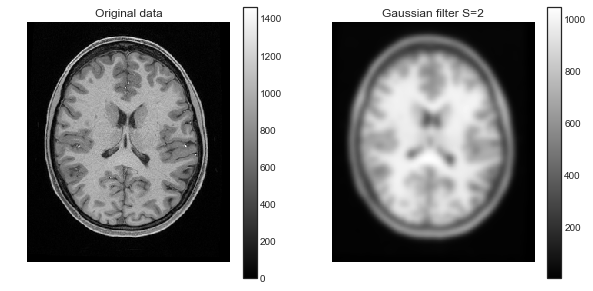

In [2]:
# Load some brain data
t1 = nibabel.load('data/HCP/100307/T1w_acpc_dc_restore.nii.gz').get_data()
# Select a single slice, convert to double and flip around so that it looks right side up
z = 120
data = t1.astype(np.double)[:,::-1,z].transpose()

# Zero pad to even multiples of 4
z_data = zeropad(data, m=4)

# Apply a Gaussian filter at a scale of 2
gz_data = gaussian_filter(z_data, scale=2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(z_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Original data')

plt.subplot(1,2,2)
plt.imshow(gz_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gaussian filter S=2')



## Downsample

Text(0.5,1,'1/4 (78, 66)')

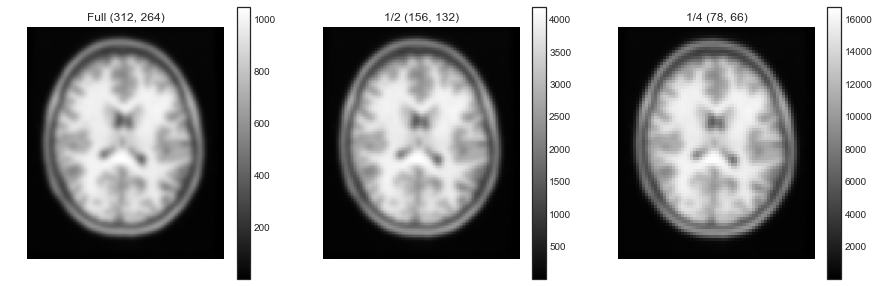

In [3]:
# Downsample the blurred image by one level
dgz_data = downsample(gz_data)
# downsample level 1 by one level again
ddgz_data = downsample(dgz_data)

plt.figure(figsize=[15,5])
plt.subplot(1,3,1)
plt.imshow(gz_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Full {}'.format(gz_data.shape))

plt.subplot(1,3,2)
plt.imshow(dgz_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('1/2 {}'.format(dgz_data.shape))

plt.subplot(1,3,3)
plt.imshow(ddgz_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('1/4 {}'.format(ddgz_data.shape))


## Usample

To be able to down and upsample by factors of 2 and end up at the same resolution, the dimensions of the image must be compatible with those operations, i.e. to downsample by 4 and then upsample back, the initial image size must be a multiple of 4 in each dimension.

Text(0.5,1,'Residual')

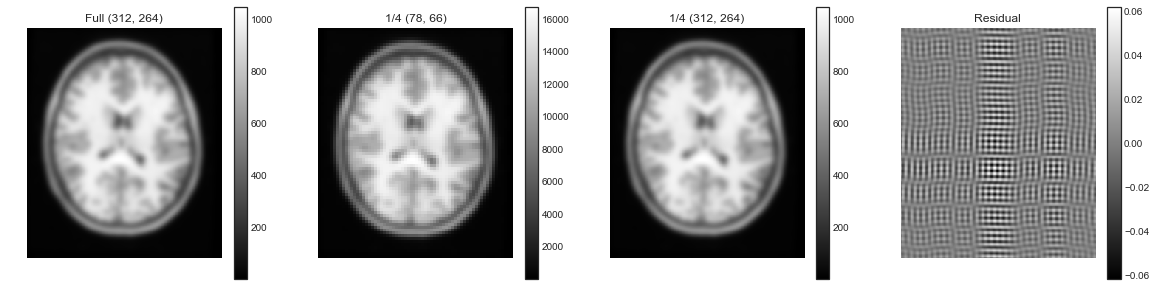

In [4]:
# Upsample by two levels
uuddgz_data = upsample(upsample(ddgz_data))

plt.figure(figsize=[20,5])
plt.subplot(1,4,1)
plt.imshow(gz_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Full {}'.format(gz_data.shape))

plt.subplot(1,4,2)
plt.imshow(ddgz_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('1/4 {}'.format(ddgz_data.shape))

plt.subplot(1,4,3)
plt.imshow(uuddgz_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('1/4 {}'.format(uuddgz_data.shape))

plt.subplot(1,4,4)
plt.imshow(gz_data - uuddgz_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Residual')
